Centroid channel: 1236.85 +/- 28.09
FWHM: 55.40 +/- 59.80
Absolute Efficiency: 5.552e-06 +/- 2.586e-06



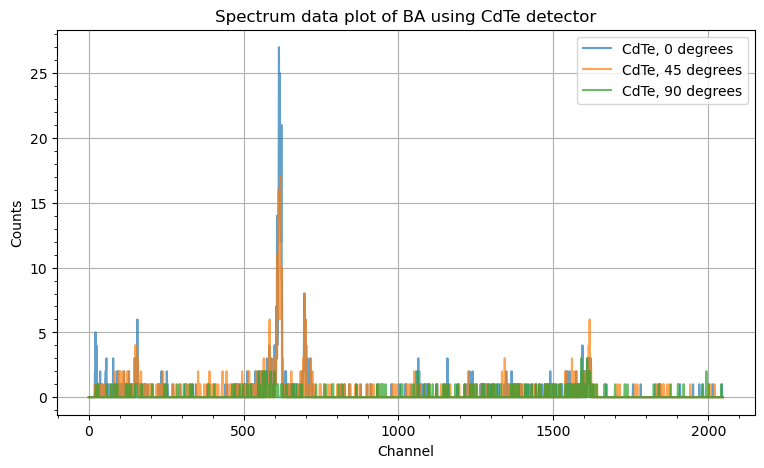

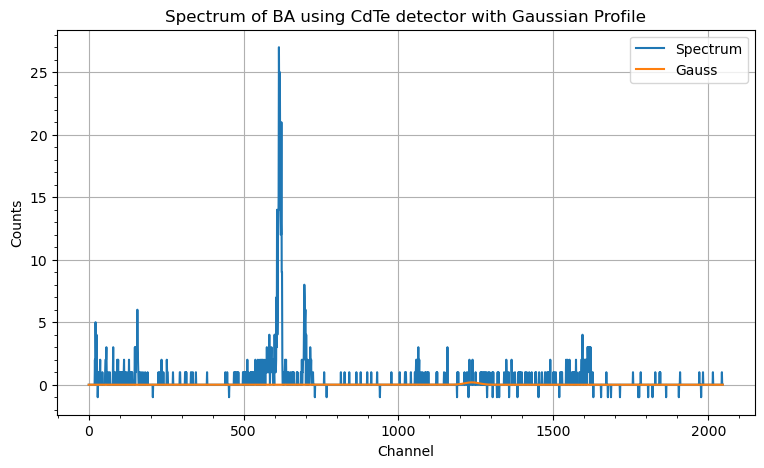

In [60]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.optimize import curve_fit


def gauss_profile(x, mu, sig, a):
    """Gaussian Function for fitting"""
    return a * np.exp(-((x - mu) ** 2) / (2 * sig ** 2))

def specplot(y):
    y = y-bg_data
    x = np.arange(len(y))
    plt.figure(figsize=(9,5))
    plt.plot(x, y, label='Spectrum')
    plt.xlabel('Channel')
    plt.ylabel('Counts')
    plt.title(f'Spectrum of {source} using {detector} detector with Gaussian Profile')
    plt.minorticks_on()
    plt.legend()
    plt.grid()

    
    p0 = [np.mean(x), np.std(x), max(y)] # Initial guess
    
    bounds = [[0, 0, 0],  # Lower bounds
              [np.inf, np.inf, np.inf]]  # Upper bounds             
    
    mask = (x  >= 1170) & (x <= 1250) ######################################################################################
    
    popt, pcov = curve_fit(gauss_profile, x[mask], y[mask], p0=p0, bounds=bounds)
    mu, sig, a = popt
    mu_err = np.sqrt(pcov[0,0])
    sig_err = np.sqrt(pcov[1,1])
    a_err = np.sqrt(pcov[2,2])

    # FWHM
    fwhm = 2 * sig * np.sqrt(2*np.log(2))
    fwhm_err = fwhm * (sig_err / sig)
    
    print(f'Centroid channel: {mu:.2f} +/- {mu_err:.2f}')
    print(f'FWHM: {fwhm:.2f} +/- {fwhm_err:.2f}')
    
    plt.plot(x, gauss_profile(x, *popt), label='Gauss')
    plt.legend()

    # Absolute Efficiency
    area = a*sig*np.sqrt(2*np.pi)   
    count_rate = area / time
    total_ph = activity * phyield 
    
    abs_eff = count_rate / total_ph
    abs_eff_err = abs_eff * (a_err / a)
    print(f'Absolute Efficiency: {abs_eff:.3e} +/- {abs_eff_err:.3e}\n')




# File path
path = 'C:/Users/Danny/Desktop/Group 4'
detector = 'CdTe'               ###############################################################################################
source = 'BA'

sfolder = f'{path}/SpectraFolder'
# Get list of files
files = glob.glob(f'{path}/{detector}_{source}*')
bg = glob.glob(f'{path}/Background_{detector}*')
bg = bg[0]

# Source characteristics
if source == 'CS':
    activity = 162430  # In Bcq
    phyield = 0.8499  
    time = 150   # In seconds

elif source == 'AM':
    activity = 412550
    phyield = 0.3578            # 26.3:0.024 , 33.2:0.00121 , 59.54:0.3578
    time = 150

elif source == 'BA':
    activity = 20350
    phyield = 0.329           # 53:0.0214 , 79:0.0265 , 81:0.329 , 276:0.0761 , 302:0.1834 , 356:0.620 , 383:0.089
    time = 300

elif source == 'CO':
    activity = 1147
    phyield = 0.9985           # 1173:0.9985 , 1332:0.999826
    time = 300


### Background ###
bg_info = []
bg_data = []

with open(bg, 'r') as file:
    indicator = False
    for line in file:
        if not indicator:
            bg_info.append(line)

        if '0 1023' in line or '<<DATA>>' in line:
            indicator = True
            continue

        if indicator:
            if '$ROI:' in line or '<<END>>' in line:
                break
            else:
                bg_data.append(int(line))
    
bg_data = np.asarray(bg_data)


### Source Spectra ###
filedata = []
plt.figure(figsize=(9, 5))

for i, file_path in enumerate(files):
    info = []
    data = []
    with open(file_path, 'r') as file:
        indicator = False
        for line in file:
            if not indicator:
                info.append(line)

            if '0 1023' in line or '<<DATA>>' in line:
                indicator = True
                continue

            if indicator:
                if '$ROI:' in line or '<<END>>' in line:
                    break
                else:
                    data.append(int(line))
    
    data = np.asarray(data)
    filedata.append(data)
    
    # Splits file name into detector, source, and angle
    parts = os.path.splitext(os.path.basename(file_path))[0].split('_')
      
    # Plots the all files from
    plt.plot(range(len(data)), data, label=f'{detector}, {parts[-1]} degrees',  alpha=0.7)
    plt.xlabel('Channel')
    plt.ylabel('Counts')
    plt.title(f'Spectrum data plot of {source} using {detector} detector')
    plt.minorticks_on()
    plt.grid()
    plt.legend()
#plt.savefig(f'{sfolder}/{detector}_{source}_spectra')


specplot(filedata[0])

